In [24]:
# Imports, as always...
import time

from collections import Counter

import cirq
import qsimcirq
import sympy
import numpy as np
from math import log, log2
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import pickle

# For generating prime numbers.
from Crypto.Util import number

# Notebook progress bars.
from tqdm.notebook import tqdm

# Scrit imports.
import sqif

# Ignoring warnings.
import warnings
warnings.filterwarnings('ignore')

# Additional imports.
from scipy.optimize import curve_fit, least_squares

# Scaling to fit to.
def scaling_function(x, alpha):
    return 1 / (2 ** (alpha * x))

# Styling for plots.
#plt.style.use('ggplot')
palette = 'deep'
sns.set_theme(style='darkgrid', palette=palette)

In [2]:
# Optimal parameters for p=10.
with open(f'./results/pre-train-parameter-assignments/p={10}.pkl', 'rb') as file:
    loaded_param_dict = pickle.load(file)
    
params = cirq.ParamResolver(loaded_param_dict)

In [3]:
# Generate a CVP instance.
n_bits = 16
cvp = sqif.CVP()
cvp.generate_cvp(N=number.getPrime(n_bits), l=1, c=3)

# Classical approx.
D, w, b_op, residual_vector, step_signs = sqif.find_b_op(cvp.B, cvp.t, delta=.75)

# Hamiltonian for refinement.
H = sqif.define_hamiltonian(D, residual_vector, step_signs)

# Build circuit.
circuit = sqif.generate_qaoa_circuit(H, p=10)

In [10]:
# Old (`run`) method of simulation...

# Time keeping.
start = time.time()

# Simulator object.
simulator = qsimcirq.QSimSimulator(
    qsimcirq.QSimOptions(cpu_threads=8, verbosity=0)
)

# Add measurements.
measurement_circuit = circuit + cirq.Circuit(cirq.measure(H.qubits, key='m'))

# Run.
result = simulator.run(measurement_circuit, param_resolver=params, repetitions=10000)

# Get histogram.
hist = result.histogram(key='m')

# Time keeping.
print(f'Runtime: {round(time.time() - start, 3)}s')

hist

Runtime: 0.135s


Counter({0: 8595,
         1: 337,
         2: 90,
         3: 252,
         4: 64,
         5: 128,
         6: 112,
         7: 37,
         8: 164,
         9: 99,
         10: 18,
         11: 4,
         12: 69,
         13: 29,
         15: 2})

In [26]:
# New (`simulate`) method of simulation...

# Time keeping.
start = time.time()

# Simulator object.
simulator = cirq.Simulator()

# Run.
state_vector = simulator.simulate(circuit, param_resolver=params).final_state_vector

# Compute probabilities
probs = {i: abs(ampl)**2 for i, ampl in enumerate(state_vector)}

# Time keeping.
print(f'Runtime: {round(time.time() - start, 3)}s')

probs

Runtime: 0.063s


{0: 0.8622978739214346,
 1: 0.03559291449666824,
 2: 0.010270425985767995,
 3: 0.026107271782614072,
 4: 0.006975234909514294,
 5: 0.010490561960772249,
 6: 0.010246533029640903,
 7: 0.0022873999949269003,
 8: 0.014058260069295392,
 9: 0.008928709122910716,
 10: 0.0016171497881925512,
 11: 0.00024804490629487877,
 12: 0.007651628282980605,
 13: 0.0028751842403679367,
 14: 5.765566907681868e-05,
 15: 0.0002942640854621814}

In [30]:
# Get lattice vectors.
lattice_vectors = sqif.integer_outcomes_to_lattice_vectors(cvp.m, np.arange(2**cirq.num_qubits(circuit)), w, D, step_signs)

In [32]:
# Final solutions objects.
display(lattice_vectors)
display(np.array(list(probs.values())))
display(b_op)

array([[    0,     4,     6,     4, 15744],
       [    5,    -4,     9,     0, 15748],
       [    5,     6,     8,    -4, 15742],
       [   10,    -2,    11,    -8, 15746],
       [    6,     4,     1,     8, 15749],
       [   11,    -4,     4,     4, 15753],
       [   11,     6,     3,     0, 15747],
       [   16,    -2,     6,    -4, 15751],
       [    5,     0,     4,     6, 15739],
       [   10,    -8,     7,     2, 15743],
       [   10,     2,     6,    -2, 15737],
       [   15,    -6,     9,    -6, 15741],
       [   11,     0,    -1,    10, 15744],
       [   16,    -8,     2,     6, 15748],
       [   16,     2,     1,     2, 15742],
       [   21,    -6,     4,    -2, 15746]])

array([8.62297874e-01, 3.55929145e-02, 1.02704260e-02, 2.61072718e-02,
       6.97523491e-03, 1.04905620e-02, 1.02465330e-02, 2.28739999e-03,
       1.40582601e-02, 8.92870912e-03, 1.61714979e-03, 2.48044906e-04,
       7.65162828e-03, 2.87518424e-03, 5.76556691e-05, 2.94264085e-04])

array([    0,     4,     6,     4, 15744])

In [37]:
# Bungle into a function.
def state_vector_solve_cvp(cvp, p, params, delta=.75):
    # Classical approx.
    D, w, b_op, residual_vector, step_signs = sqif.find_b_op(cvp.B, cvp.t, delta=delta)
    
    # Hamiltonian for refinement.
    H = sqif.define_hamiltonian(D, residual_vector, step_signs)
    
    # Build circuit.
    circuit = sqif.generate_qaoa_circuit(H, p=p)
    
    # Simulator object.
    simulator = cirq.Simulator()
    
    # Run.
    state_vector = simulator.simulate(circuit, param_resolver=params).final_state_vector
    
    # Compute probabilities
    probs = {i: abs(ampl)**2 for i, ampl in enumerate(state_vector)}
    
    # Get lattice vectors.
    lattice_vectors = sqif.integer_outcomes_to_lattice_vectors(cvp.m, np.arange(2**cirq.num_qubits(circuit)), w, D, step_signs)
    
    return lattice_vectors, np.array(list(probs.values())), b_op

  0%|          | 0/10 [00:00<?, ?it/s]

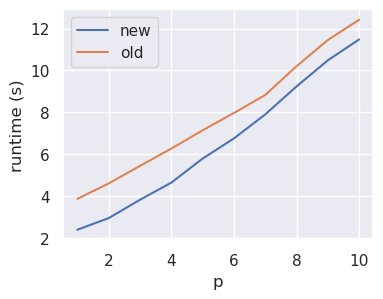

In [42]:
# Runtime comparison.

new_times = []
old_times = []

ps = list(range(1, 11))

for p in tqdm(ps):
    with open(f'./results/pre-train-parameter-assignments/p={p}.pkl', 'rb') as file:
        loaded_param_dict = pickle.load(file)
        
    params = cirq.ParamResolver(loaded_param_dict)
    
    tic = time.perf_counter()
    for n_bits in range(16, 65):
        cvp = sqif.CVP()
        cvp.generate_cvp(N=number.getPrime(n_bits), l=1, c=3)
        _ = state_vector_solve_cvp(cvp, p, params)
    toc = time.perf_counter()
    
    new_times.append(toc - tic)
    
    tic = time.perf_counter()
    for n_bits in range(16, 65):
        cvp = sqif.CVP()
        cvp.generate_cvp(N=number.getPrime(n_bits), l=1, c=3)
        _ = sqif.solve_cvp(cvp, n_samples=10000, p=p, optimal_parameters=params, verbose=False)
    toc = time.perf_counter()
    
    old_times.append(toc - tic)
    
_, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(ps, new_times, label='new')
ax.plot(ps, old_times, label='old')

ax.set_xlabel('p')
ax.set_ylabel('runtime (s)')
ax.legend()

  0%|          | 0/97 [00:00<?, ?it/s]

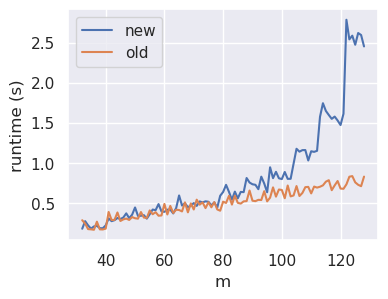

In [46]:
# Runtime comparison.

new_times = []
old_times = []

with open(f'./results/pre-train-parameter-assignments/p={10}.pkl', 'rb') as file:
    loaded_param_dict = pickle.load(file)
    
params = cirq.ParamResolver(loaded_param_dict)
    
bit_lengths = list(range(32, 129))
for n_bits in tqdm(bit_lengths):
    
    cvp = sqif.CVP()
    cvp.generate_cvp(N=number.getPrime(n_bits), l=1, c=3)

    tic = time.perf_counter()
    _ = state_vector_solve_cvp(cvp, 10, params)
    toc = time.perf_counter()
    
    new_times.append(toc - tic)
    
    tic = time.perf_counter()
    _ = sqif.solve_cvp(cvp, n_samples=10000, p=10, optimal_parameters=params, verbose=False)
    toc = time.perf_counter()
    
    old_times.append(toc - tic)
    
_, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(bit_lengths, new_times, label='new')
ax.plot(bit_lengths, old_times, label='old')

ax.set_xlabel('m')
ax.set_ylabel('runtime (s)')
ax.legend()